# Reconstruction of uniaxial permittivity tensor (uPT) in 2D
This reconstruction is based on the uPTI paper [here](https://www.biorxiv.org/content/10.1101/2020.12.15.422951v1): <br>
``` L.-H. Yeh, I. E. Ivanov, B. B. Chhun, S.-M. Guo, E. Hashemi, J. R. Byrum, J. A. Pérez-Bermejo, H. Wang, Y. Yu, P. G. Kazansky, B. R. Conklin, M. H. Han, and S. B. Mehta, "uPTI: uniaxial permittivity tensor imaging of intrinsic density and anisotropy," bioRxiv 2020.12.15.422951 (2020).```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftn, ifftn, fftshift, ifftshift

import pickle
import waveorder as wo

import time

%matplotlib inline

## Initialization

### Load simulated images and parameters

In [2]:
# Load simulations


file_name = 'uPTI_simulation_data_NA_det_147_NA_illu_140_2D_spoke_discrete_no_1528_ne_1553_no_noise_Born.npz'

array_loaded = np.load(file_name)
list_of_array_names = sorted(array_loaded)

for array_name in list_of_array_names:
    globals()[array_name] = array_loaded[array_name]

print(list_of_array_names)

I_meas = np.transpose(I_meas[:,:,:,:,50],(0,2,3,1))
z_defocus = np.array([0])

I_meas = I_meas[1:]
I_meas.shape


['I_meas', 'NA_illu', 'NA_obj', 'Source_PolState', 'Source_cont', 'chi', 'lambda_illu', 'n_media', 'ps', 'psz', 'z_defocus']


(4, 200, 200, 9)

### Initiate the reconstruction


In [3]:
_, N, M, _ = I_meas.shape
cali        = False               
bg_option   = 'global'            
use_gpu = True
gpu_id = 0

# chi = pi/2

A_matrix = 0.5*np.array([[1, 1, 0], \
                         [1, 0, 1], \
                         [1, -1, 0], \
                         [1, 0, -1]])


setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media=n_media, cali=cali, phase_deconv='2D', \
                                A_matrix=A_matrix, inc_recon='2D-vec-WOTF', \
                                illu_mode='Arbitrary', Source = Source_cont, Source_PolState=Source_PolState, \
                                use_gpu=use_gpu, gpu_id=gpu_id)


## Visualize 2D transfer functions as a function of illumination pattern

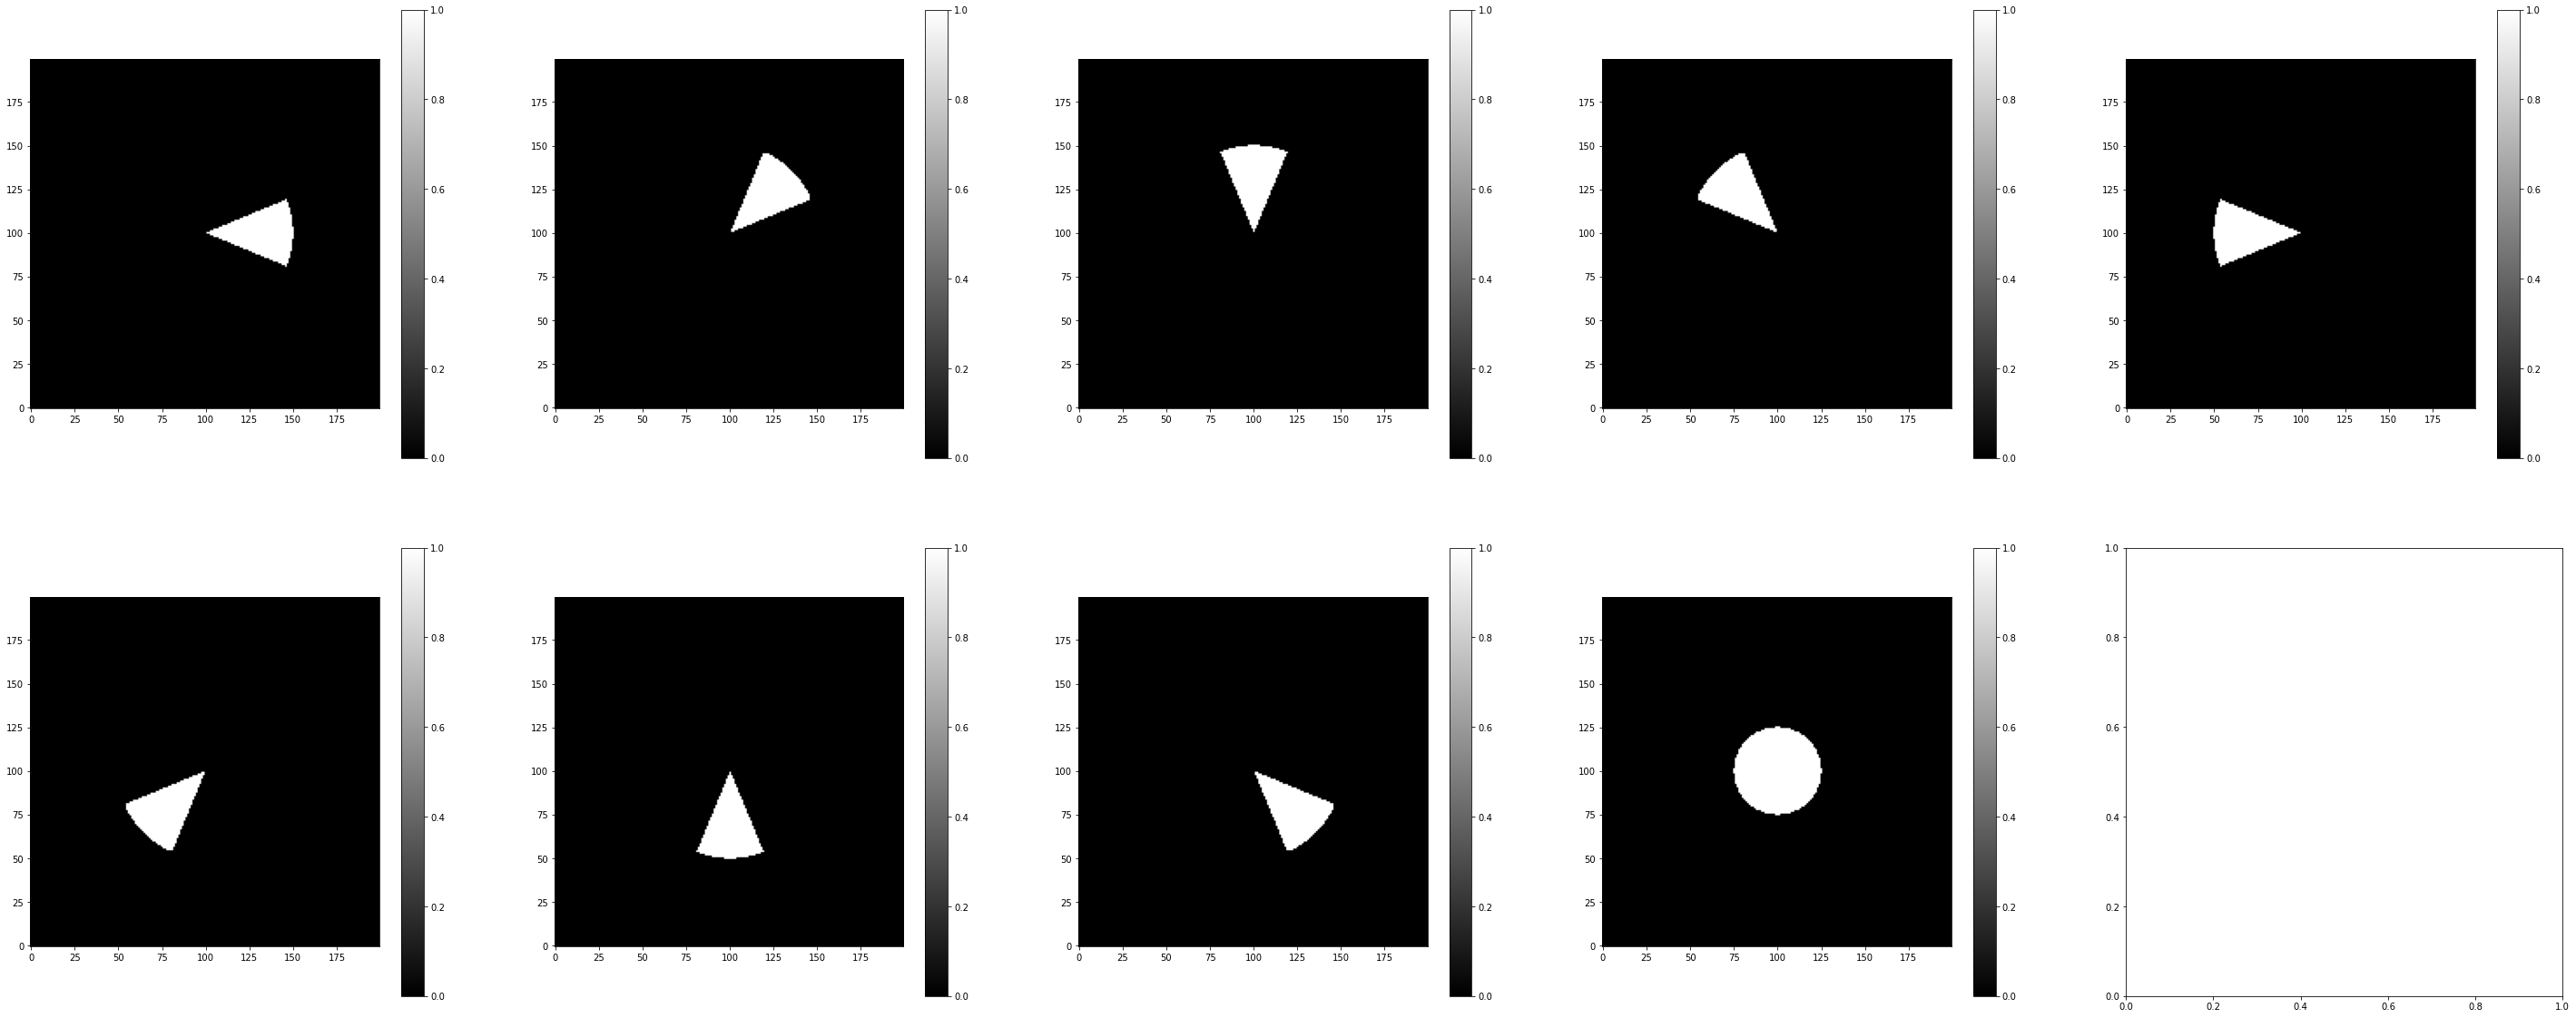

In [4]:
# illumination patterns used
wo.plot_multicolumn(fftshift(Source_cont,axes=(1,2)), origin='lower', num_col=5)

In [5]:
plot_list = []
plot_list_abs = []
for i in range(3):
    for j in range(7):
        OTF_fftshift = fftshift(setup.H_dyadic_2D_OTF[i,j],axes=(0,1))
        
        plot_list.append(np.real(OTF_fftshift))
        plot_list.append(np.imag(OTF_fftshift))
        plot_list_abs.append(np.abs(OTF_fftshift))
        
normalization_energy = np.max(np.sum(np.stack(plot_list_abs),axis=3),axis=(1,2))[1]


# generate strings for plotting
spt_list = [r'0r', r'0i', r'1c', r'1s', r'2c', r'2s', r'3']
stokes_list = [r'0', r'1', r'2']
reim_list = [r'Re', r'Im']

sum_transfer_function_titles = []
transfer_function_titles = []

for stokes_idx in stokes_list:
    for spt_idx in spt_list:
        sum_transfer_function_titles.append(r'$\sum_{\alpha} \tilde{H}_{'+stokes_idx+r', '+spt_idx+r', \alpha}$')

for stokes_idx in stokes_list:
    for spt_idx in spt_list:
        for reim_idx in reim_list:
            transfer_function_titles.append(r'$'+reim_idx+r'\{\tilde{H}_{'+stokes_idx+r', '+spt_idx+r', \alpha}\}$')


In [6]:
# the sum of transfer functions over all patterns
wo.parallel_4D_viewer(np.sum(np.abs(np.transpose(np.stack(plot_list_abs), (3,0,1,2)))/normalization_energy,axis=0)[np.newaxis,...],\
                      num_col=7, size=8, colormap='jet', origin='lower', vrange=[0, 1], \
                      set_title=True, titles=sum_transfer_function_titles)

interactive(children=(IntSlider(value=0, description='stack_idx', max=0), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [7]:
# animate transfer functions through different illumination patterns

# wo.parallel_4D_viewer(np.transpose(np.stack(plot_list)/normalization_energy, (3,0,1,2)), \
#                       num_col=14, size=5, colormap='jet', origin='lower', vrange=[-0.1, 0.1], \
#                       set_title=True, titles=transfer_function_titles)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

## Reconstruct Stokes images and visualize them as a function of illumination pattern

In [7]:
S_image_recon = setup.Stokes_recon(I_meas)

S_image_tm = np.zeros_like(S_image_recon)

S_bg_mean_0 = np.mean(S_image_recon[0,:,:,:], axis=(0,1))[np.newaxis,np.newaxis,:]
S_bg_mean_1 = np.mean(S_image_recon[1,:,:,:], axis=(0,1))[np.newaxis,np.newaxis,:]
S_bg_mean_2 = np.mean(S_image_recon[2,:,:,:], axis=(0,1))[np.newaxis,np.newaxis,:]


S_image_tm[0] = S_image_recon[0]/S_bg_mean_0-1
S_image_tm[1] = S_image_recon[1]/S_bg_mean_0 - S_bg_mean_1*S_image_recon[0]/S_bg_mean_0**2
S_image_tm[2] = S_image_recon[2]/S_bg_mean_0 - S_bg_mean_2*S_image_recon[0]/S_bg_mean_0**2


In [8]:
wo.parallel_4D_viewer(np.transpose(S_image_recon,(3,0,1,2)), num_col=3, size=5, \
                      set_title=True, titles=[r'$S_0$', r'$S_1$', r'$S_2$'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [9]:
wo.parallel_4D_viewer(np.transpose(S_image_tm,(3,0,1,2)), num_col=3, size=5, \
                      set_title=True, titles=[r'$S_0$', r'$S_1$', r'$S_2$'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

## 2D uPTI reconstruction

### Compute the components of the scattering potential tensor

In [13]:
reg_inc = np.array([1, 1, 1, 1, 1, 1, 1])*1e-1

reg_ret_pr = 1e-2

f_tensor = setup.scattering_potential_tensor_recon_2D_vec(S_image_tm, reg_inc=reg_inc, cupy_det=True)

Finished preprocess, elapsed time: 0.11
Finished reconstruction, elapsed time: 0.39


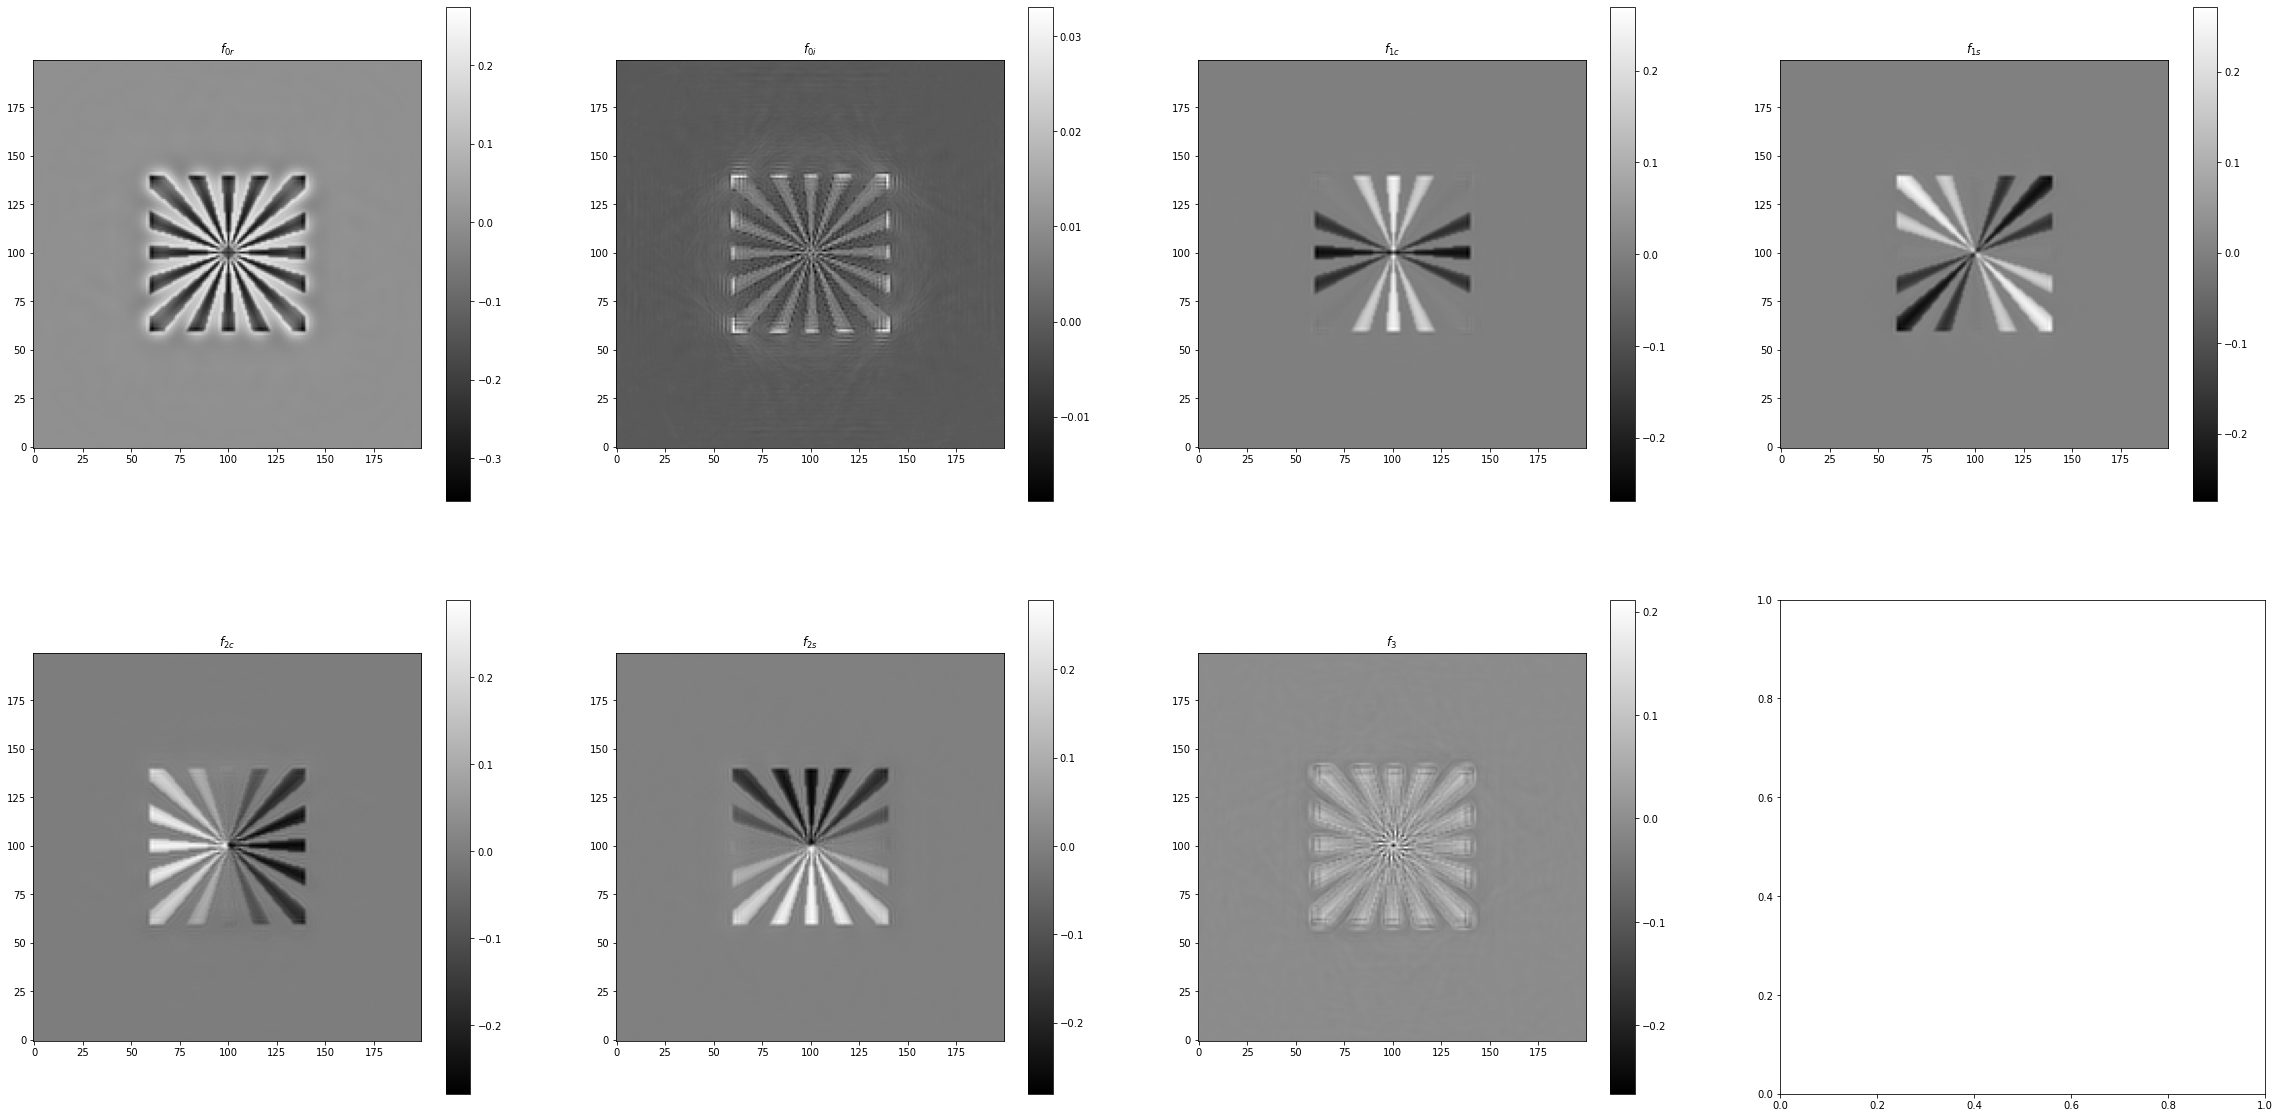

In [14]:
wo.plot_multicolumn(f_tensor, num_col=4, origin='lower', 
                    set_title=True, titles=[r'$f_{0r}$', r'$f_{0i}$', r'$f_{1c}$',r'$f_{1s}$',\
                                            r'$f_{2c}$', r'$f_{2s}$', r'$f_{3}$'])

### Estimate principal retardance, orientation, inclination, and optic axis from the scattering potential tensor

Finish optic sign estimation, elapsed time: 15.17


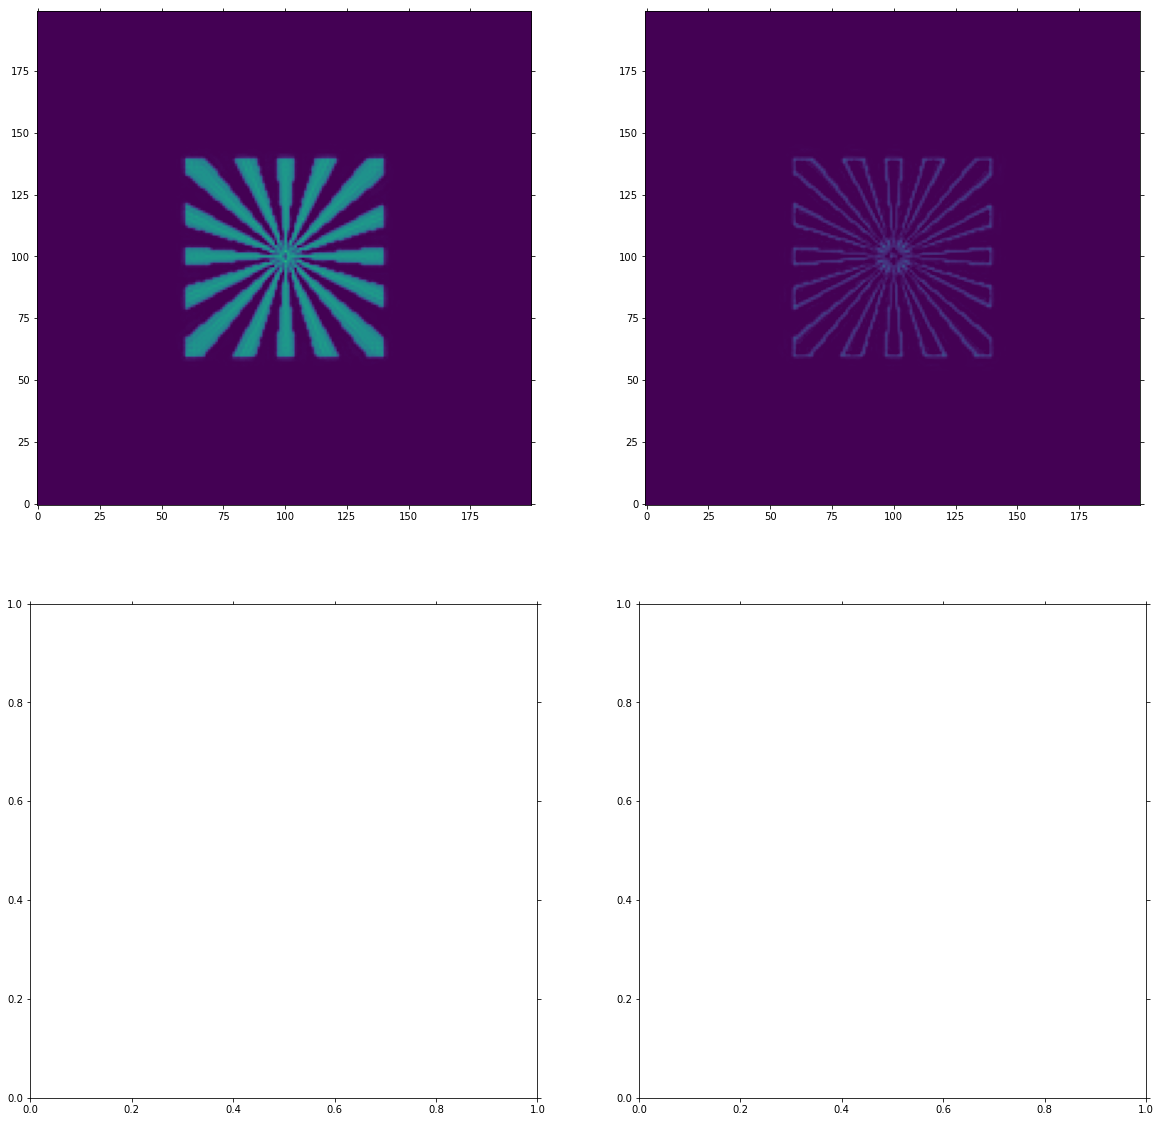

In [15]:
retardance_pr, azimuth, theta, mat_map = setup.scattering_potential_tensor_to_3D_orientation(f_tensor, S_image_tm,\
                                                                                             material_type='unknown', reg_ret_pr = reg_ret_pr, itr=20, step_size=0.1, fast_gpu_mode=True)

In [16]:
# scaling to the physical properties of the material

# optic sign probability
p_mat_map = wo.optic_sign_probability(mat_map,mat_map_thres=0.1)

# absorption and phase
phase = wo.phase_inc_correction(f_tensor[0], retardance_pr[0], theta[0])
absorption = f_tensor[1].copy()
phase_nm, absorption_nm, retardance_pr_nm = [wo.unit_conversion_from_scattering_potential_to_permittivity(SP_array, lambda_illu, n_media=n_media, imaging_mode = img_mode) 
                                             for img_mode, SP_array in zip(['2D', '2D', '2D-ret'],[phase, absorption, retardance_pr])]



In [17]:
# clean up GPU memory leftorver

import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

## Visualize reconstructed physical properties of simulated sample

### Phase, principal retardance, azimuth, inclination, and optic sign

Text(0.5, 1.0, 'inclination (+)')

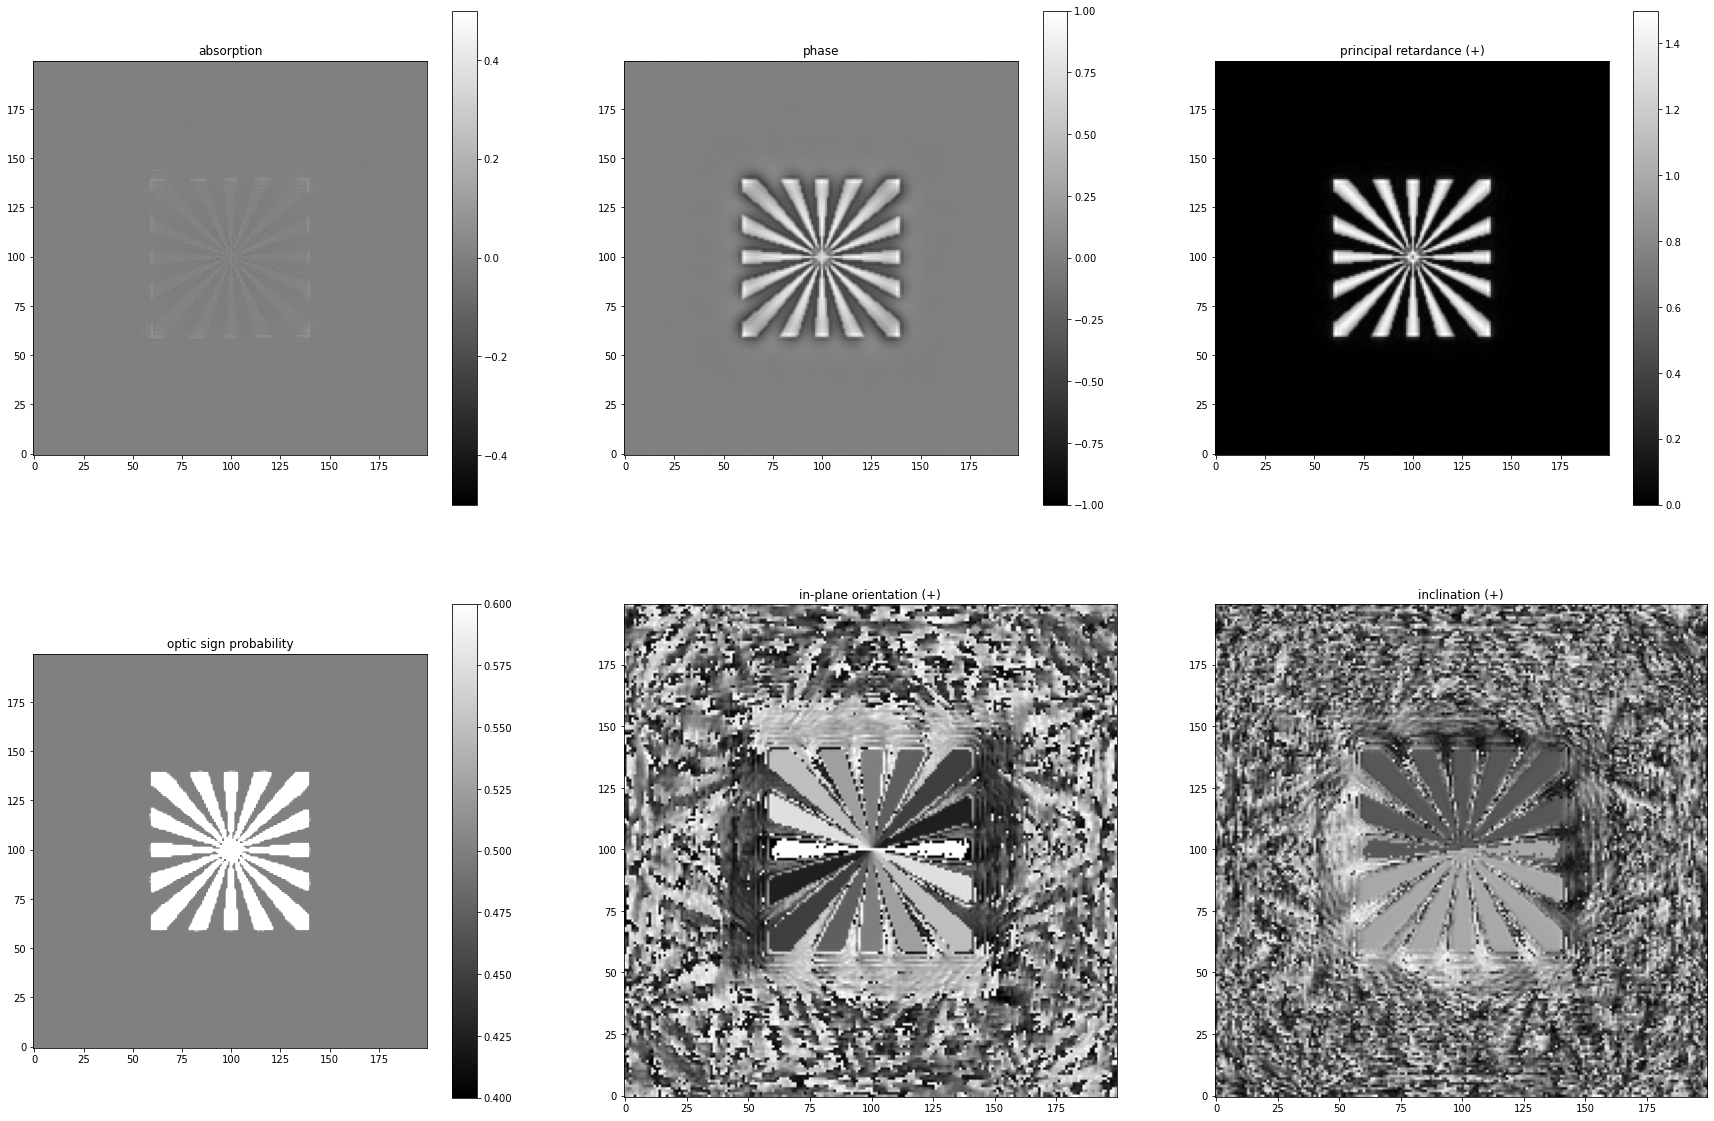

In [21]:
abs_min = -0.5
abs_max = 0.5
phase_min = -1
phase_max = 1
ret_min = 0
ret_max = 1.5
p_min = 0.4
p_max = 0.6


fig,ax = plt.subplots(2,3,figsize=(30,20))

sub_ax = ax[0,0].imshow(absorption_nm, cmap='gray', origin='lower', vmin=abs_min, vmax=abs_max)
ax[0,0].set_title('absorption')
plt.colorbar(sub_ax, ax=ax[0,0])

sub_ax = ax[0,1].imshow(phase_nm, cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
ax[0,1].set_title('phase')
plt.colorbar(sub_ax, ax=ax[0,1])

sub_ax = ax[0,2].imshow(np.abs(retardance_pr_nm[0]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
ax[0,2].set_title('principal retardance (+)')
plt.colorbar(sub_ax, ax=ax[0,2])

sub_ax = ax[1,0].imshow(p_mat_map, cmap='gray', origin='lower',vmin=p_min, vmax=p_max)
ax[1,0].set_title('optic sign probability')
plt.colorbar(sub_ax, ax=ax[1,0])

sub_ax = ax[1,1].imshow(azimuth[0], origin='lower',cmap='gray',vmin=0, vmax=np.pi)
ax[1,1].set_title('in-plane orientation (+)')

sub_ax = ax[1,2].imshow(theta[0], origin='lower',cmap='gray',vmin=0, vmax=np.pi)
ax[1,2].set_title('inclination (+)')


### Render 3D orientation with 3D colorsphere (azimuth and inclination)

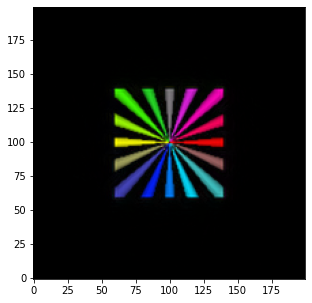

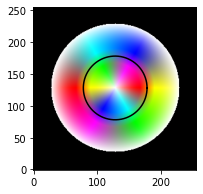

In [25]:
# rendering with 3D color

ret_min_color = 0
ret_max_color = 1.5

orientation_3D_image = np.transpose(np.array([azimuth[0]/2/np.pi, theta[0], (np.clip(np.abs(retardance_pr_nm[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]),(1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)

plt.figure(figsize=(5,5))
plt.imshow(orientation_3D_image_RGB, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

### Render 3D orientation with 2 channels (in-plane orientation and out-of-plane tilt)

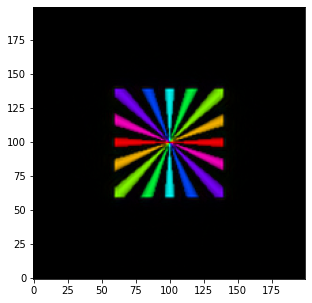

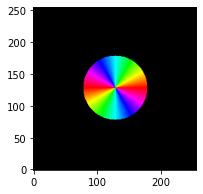

In [31]:
# in-plane orientation
from matplotlib.colors import hsv_to_rgb


ret_min_color = 0
ret_max_color = 1.5


I_hsv = np.transpose(np.array([(azimuth[0])%np.pi/np.pi, \
                               np.ones_like(retardance_pr_nm[0]), \
                               (np.clip(np.abs(retardance_pr_nm[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (1,2,0))
in_plane_orientation = hsv_to_rgb(I_hsv.copy())

plt.figure(figsize=(5,5))
plt.imshow(in_plane_orientation, origin='lower')
plt.figure(figsize=(3,3))
wo.orientation_2D_colorwheel()

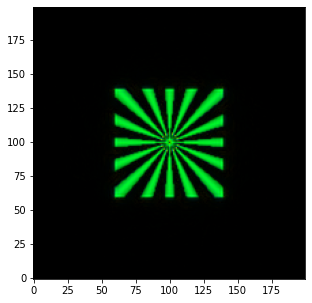

In [36]:
# out-of-plane tilt

threshold_inc = np.pi/90

I_hsv = np.transpose(np.array([(-np.maximum(0,np.abs(theta[0]-np.pi/2)-threshold_inc)+np.pi/2+threshold_inc)/np.pi, \
                               np.ones_like(retardance_pr_nm[0]), \
                               (np.clip(np.abs(retardance_pr_nm[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (1,2,0))
out_of_plane_tilt = hsv_to_rgb(I_hsv.copy())

plt.figure(figsize=(5,5))
plt.imshow(out_of_plane_tilt, origin='lower')

## Evaluation of reconstructed 3D orientation

### 3D orientation overlaid as lines on retardance image.

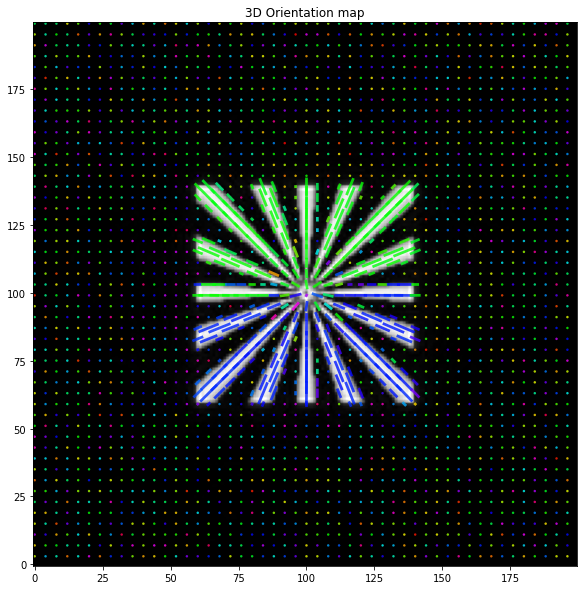

In [37]:

spacing = 4


# plt.figure(figsize=(10,10))

fig,ax = plt.subplots(1,1,figsize=(20,10))
wo.plot3DVectorField(np.abs(retardance_pr_nm[0]), azimuth[0], theta[0], 
                     anisotropy=0.4*np.abs(retardance_pr_nm[0]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=spacing, linelength=spacing, linewidth=1, cmapAzimuth='hsv', alpha=0.8, subplot_ax=ax)



### Angular histogram of computed 3D orientation

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

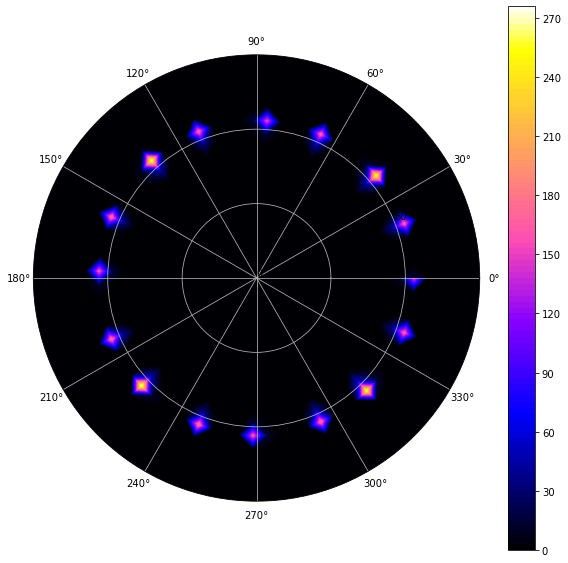

In [38]:
# Angular histogram of 3D orientation
ret_mask = np.abs(retardance_pr_nm[0]).copy()
ret_mask[ret_mask<0.5]=0

#plt.figure(figsize=(10,10))
#plt.imshow(ret_mask, cmap='gray', origin='lower')
wo.orientation_3D_hist(azimuth[0].flatten(), \
                       theta[0].flatten(), \
                       ret_mask.flatten(),\
                       bins=36, num_col=1, size=10, contour_level = 100, hist_cmap='gnuplot2', top_hemi=True)

In [39]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()